In [1]:
%pylab inline
from sklearn import datasets
from sklearn.model_selection import train_test_split
np.set_printoptions(precision=3, suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
# сгенерируем набор данных
data, target, coef = datasets.make_regression(n_samples=10000, n_features = 2, n_informative = 2, n_targets = 1, 
                                              noise = 7, coef = True, random_state = 2)
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.7, random_state = 0)
train_target = np.reshape(train_target, (-1, 1))
test_target = np.reshape(test_target, (-1, 1))

In [3]:
coef

array([47.461,  1.665])

In [4]:
def calc_mse(y, y_pred):
    return np.mean((y - y_pred)**2)

def calc_r2(y, y_pred):
    return 1 - np.sum((y - y_pred)**2) / np.sum((y - np.mean(y))**2)



In [5]:
def sgd(X, y, alpha, lambda_ = 0, type_reg = 0, batch_size = -1, is_stochastic = True, errors = [], epoch_errors = [], weights = []):
    epsilon = 1e-3
    W = np.random.random((2, 1)) * 100 - 10
    n = X.shape[0]
    if batch_size < 0:
        batch_size = n
    nb = n // batch_size + (1 if n % batch_size else 0) 
    exit = False
    max_iterations = 10000
    i = 0
    no_step_count = 0
    while not exit:
        indexes = np.random.randint(0, n, n) if is_stochastic else range(n)
        for j in range(nb):
            batch_indexes = indexes[j * batch_size: (j + 1) * batch_size]
            Xb = X[batch_indexes]
            yb = y[batch_indexes]
            y_pred = Xb.dot(W)
            err = calc_mse(yb, y_pred)
            errors.append(err)
            weights.append(np.copy(W.T[0]))
            D = 1/batch_size * 2 * Xb.T.dot(y_pred - yb)
            if type_reg == 2:
                D += lambda_ * W
            elif type_reg == 1:
                D += lambda_ * np.sign(W) 
            D *= alpha 
#            print(j, batch_indexes, Xb, yb, y_pred, y_pred - yb, D, np.linalg.norm(D))
            i += 1 
            if np.linalg.norm(D) < epsilon:
                no_step_count += 1
            else:
                no_step_count = 0
            if no_step_count >= 3 or i >= max_iterations: # выходим, если несколько раз подряд изменение шага < epsilon, иначе иногда случайно выходит далеко от оптимума
                exit = True
                break
            W -= D
        epoch_errors.append(calc_mse(y, X.dot(W)))
    return W

In [6]:
def test(params):
    results = []
    plt.figure(figsize=(18,6))
    plt.title('MSE')
    plt.xlabel('Iteration number')
    plt.ylabel('MSE')
    plots = []
    n_err = 1000
    for p in params:
        errors = []
        epoch_errors = []
        weights = []
        batch_size = p[3]
        if batch_size < 0:
            batch_size = train_data.shape[0]
        W = sgd(train_data, train_target, p[0], p[1], p[2], batch_size, p[4], errors, epoch_errors, weights)
        l = f"alpha = {p[0]}, {'стохастический' if p[4] else 'обычный'}, размер батча: {batch_size}"
        if p[2] == 2:
            l += ", L2 (Ridge)"
        elif p[2] == 1:
            l += ", L1 (LASSO)"
        if p[2] > 0 and p[1] > 0: 
            l += f", lambda = {p[1]}"
            
        train_r2 = calc_r2(train_target, train_data.dot(W))
        test_r2 = calc_r2(test_target, test_data.dot(W))
        print(f"{l} -- число итераций: {len(errors)}, число эпох: {len(epoch_errors)}, W = ", W.T[0], 
              f', тест. R2 = {test_r2:0.3f}, трен. R2 = {train_r2:0.3f}')
        p, = plt.plot(range(len(errors[0:n_err])), errors[0:n_err], label=l)
        plots.append(p)
        results.append({'label': l, 'solution': W.T[0], 'weights': weights, 'errors': errors, 'epoch_errors': epoch_errors, 
                        'train_r2': train_r2, 'test_r2': test_r2})
    plt.legend(handles=plots)
    plt.show()
    
    A = train_data.T.dot(train_data) # матрица квадратичной формы целевой функции X.T * X

    def err_func(w1, w2):
        wc = np.array([w1, w2]) - coef # смещаем в известное решение, можно показать, что матрица A не изменится
        return wc.dot(A).dot(wc)

    cgw1, cgw2 = np.meshgrid(np.arange(coef[0] - 100, coef[0] + 100, 0.5), np.arange(coef[1] - 100, coef[1] + 100, 0.5))
    cge = np.vectorize(err_func)(cgw1, cgw2)

    f, table = plt.subplots(len(results), 2, figsize=(18, len(results) * 4), gridspec_kw={'width_ratios': [3, 1]})
    f.tight_layout()
    if len(results) == 1: # если len(results) == 1 - возвращается одномерный массив
        table = [table]
    for ri in range(len(results)):
        r = results[ri]
        row = table[ri]
        row[0].plot(range(len(r['errors'][0:n_err])), r['errors'][0:n_err])
        row[1].contour(cgw1, cgw2, cge, 20)
        w = np.array(r['weights']).T
        row[1].plot(w[0], w[1])
        row[0].title.set_text(f"{r['label']}: тест. R2 = {r['test_r2']:0.3f}, трен. R2 = {r['train_r2']:0.3f}, W=" + str(r['solution']))
    
    plt.show()

alpha = 0.01, стохастический, размер батча: 1 -- число итераций: 152, число эпох: 1, W =  [47.722  4.665] , тест. R2 = 0.974, трен. R2 = 0.975
alpha = 0.01, обычный, размер батча: 1 -- число итераций: 62, число эпох: 1, W =  [21.81  25.293] , тест. R2 = 0.448, трен. R2 = 0.450
alpha = 0.01, стохастический, размер батча: 200 -- число итераций: 262, число эпох: 18, W =  [47.661  1.889] , тест. R2 = 0.978, трен. R2 = 0.979
alpha = 0.01, обычный, размер батча: 200 -- число итераций: 252, число эпох: 17, W =  [47.153  1.945] , тест. R2 = 0.978, трен. R2 = 0.979
alpha = 0.01, стохастический, размер батча: 3000 -- число итераций: 260, число эпох: 260, W =  [47.378  1.717] , тест. R2 = 0.978, трен. R2 = 0.979
alpha = 0.01, обычный, размер батча: 3000 -- число итераций: 350, число эпох: 350, W =  [47.457  1.594] , тест. R2 = 0.978, трен. R2 = 0.979


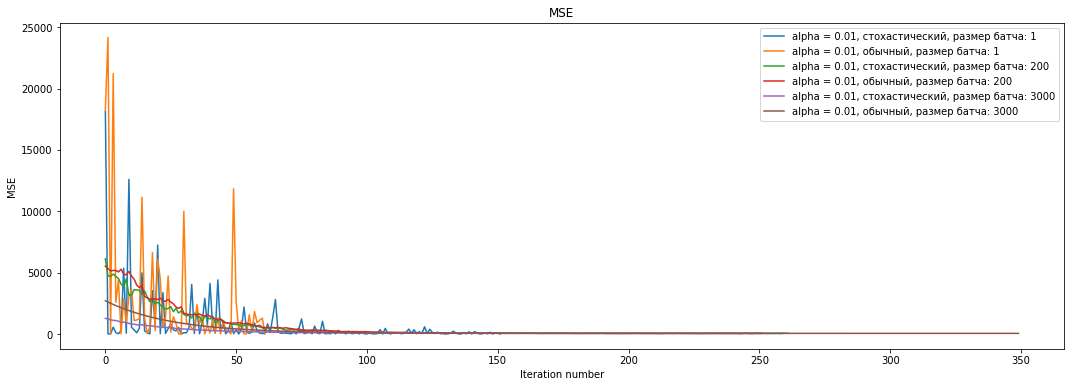

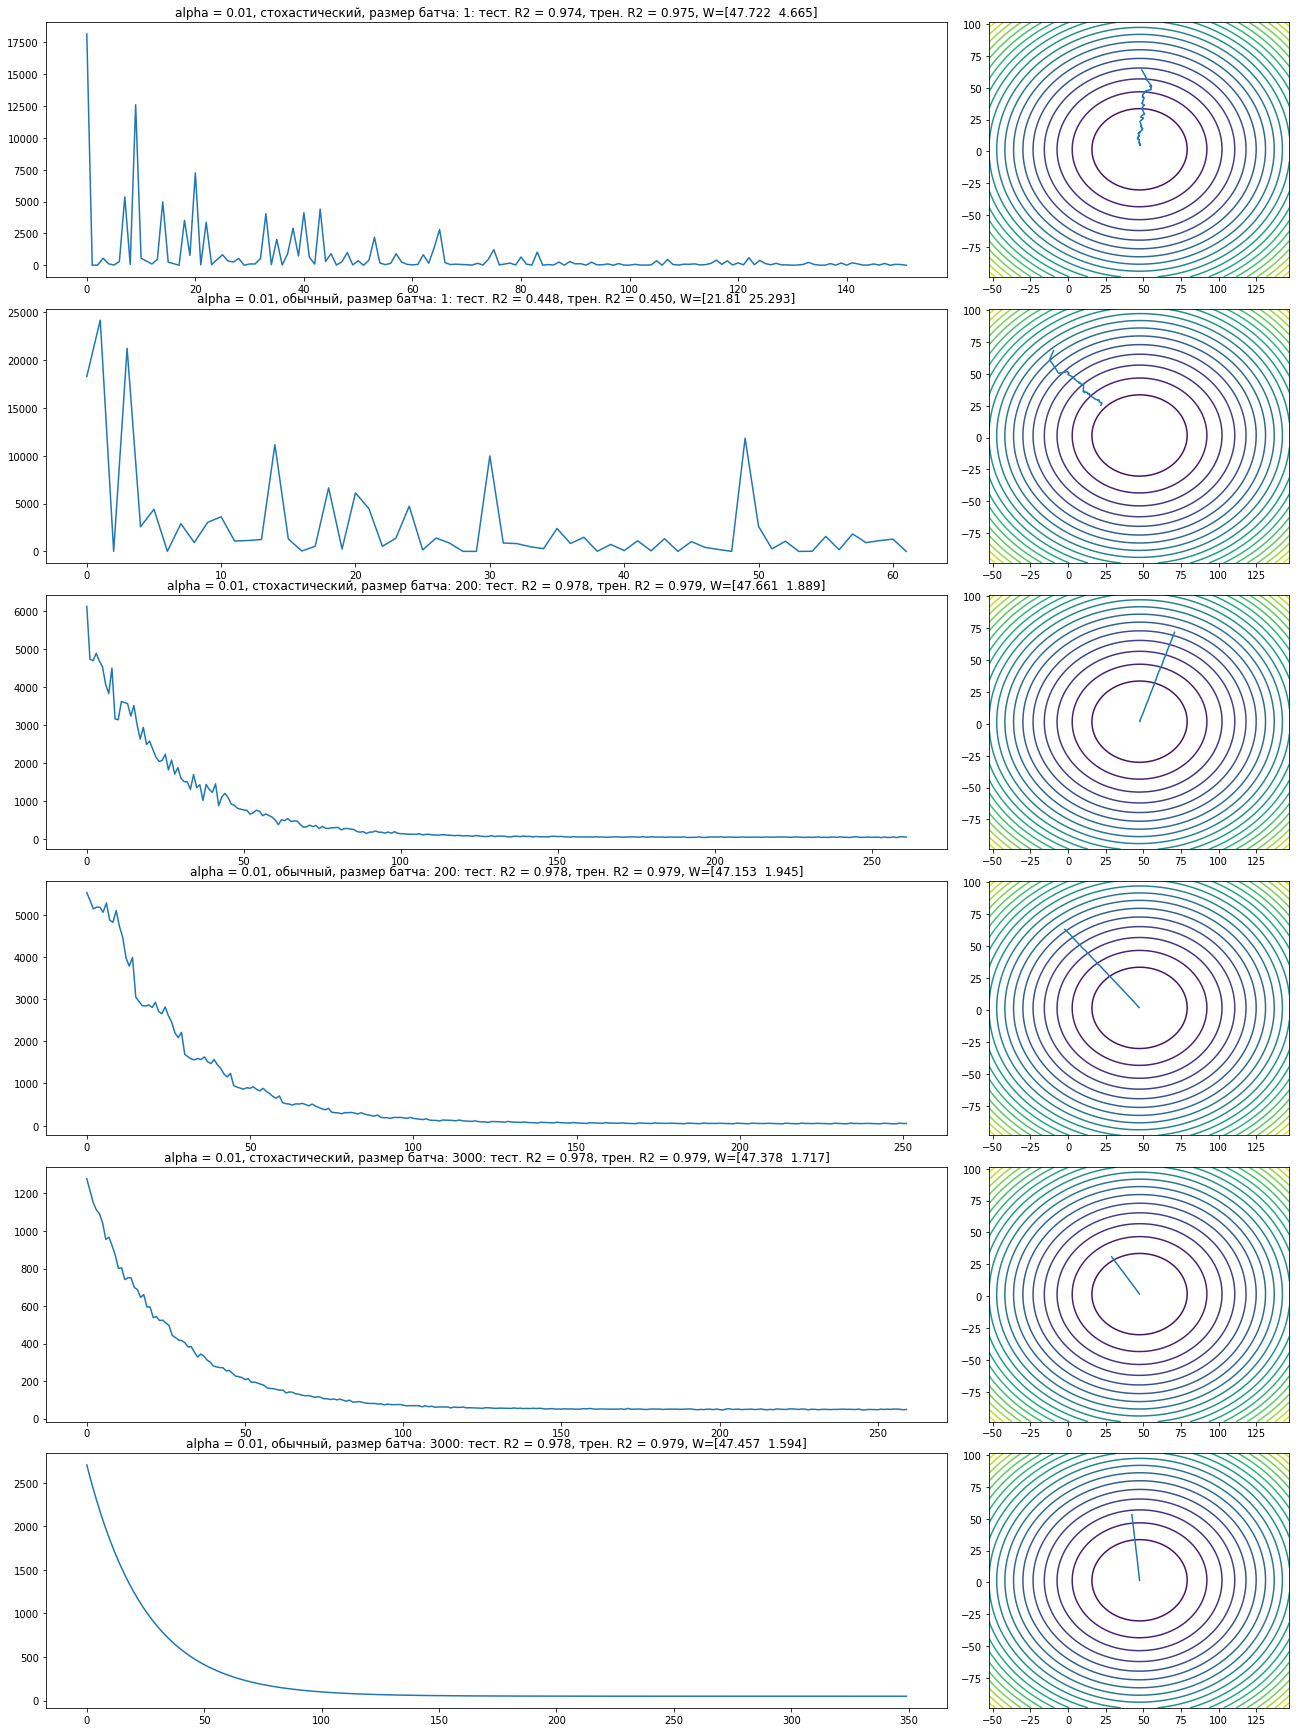

In [7]:
alpha = 0.01
test([
    (alpha, 0, 0, 1, True), 
    (alpha, 0, 0, 1, False),
    (alpha, 0, 0, 200, True), 
    (alpha, 0, 0, 200, False),
    (alpha, 0, 0, -1, True), 
    (alpha, 0, 0, -1, False)
])


alpha = 0.01, стохастический, размер батча: 1, L2 (Ridge), lambda = 0.01 -- число итераций: 520, число эпох: 1, W =  [47.869  1.035] , тест. R2 = 0.978, трен. R2 = 0.979
alpha = 0.01, стохастический, размер батча: 200, L2 (Ridge), lambda = 0.01 -- число итераций: 297, число эпох: 20, W =  [47.315  1.525] , тест. R2 = 0.978, трен. R2 = 0.979
alpha = 0.01, стохастический, размер батча: 1, L2 (Ridge), lambda = 0.1 -- число итераций: 10000, число эпох: 4, W =  [45.232 -0.348] , тест. R2 = 0.974, трен. R2 = 0.975
alpha = 0.01, стохастический, размер батча: 200, L2 (Ridge), lambda = 0.1 -- число итераций: 223, число эпох: 15, W =  [44.924  2.283] , тест. R2 = 0.975, трен. R2 = 0.976
alpha = 0.01, стохастический, размер батча: 1, L2 (Ridge), lambda = 1 -- число итераций: 10000, число эпох: 4, W =  [34.191  2.057] , тест. R2 = 0.902, трен. R2 = 0.902
alpha = 0.01, стохастический, размер батча: 200, L2 (Ridge), lambda = 1 -- число итераций: 285, число эпох: 19, W =  [31.702  0.853] , тест. R2 =

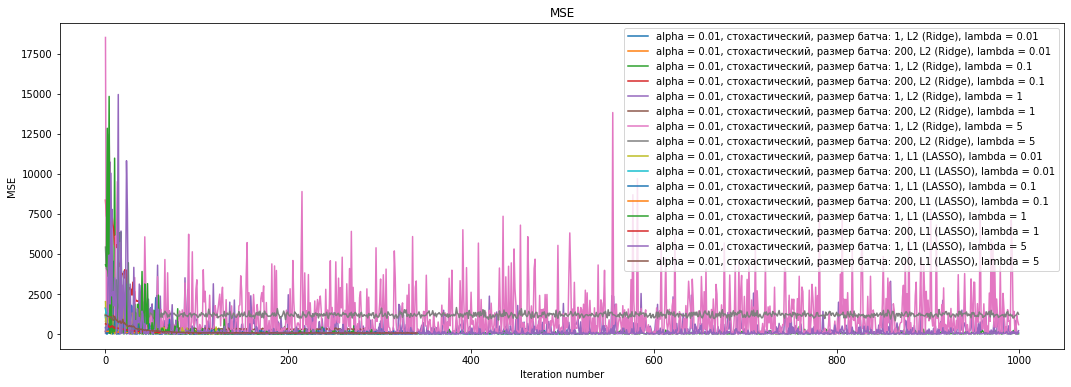

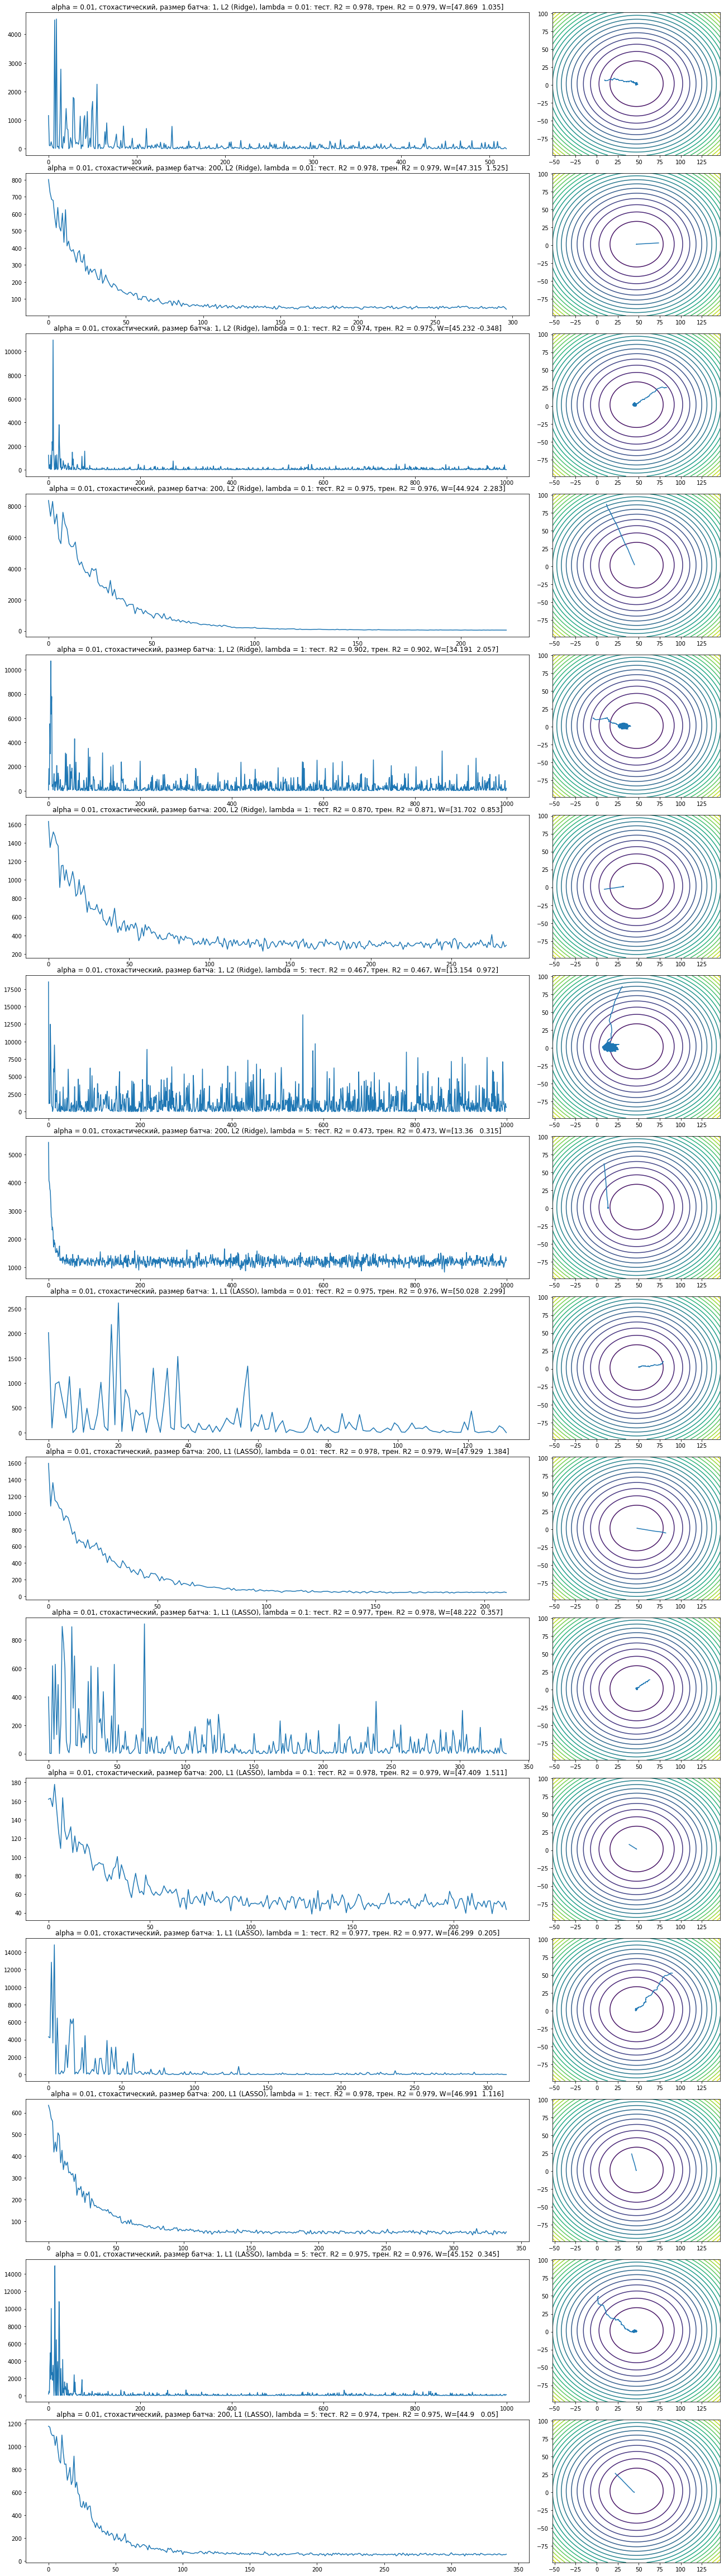

In [8]:
alpha = 0.01
params = []
for tr in [2, 1]:
    for lambda_ in [0.01, 0.1, 1, 5]:
        params += [
            (alpha, lambda_, tr, 1, True), 
            (alpha, lambda_, tr, 200, True), 
        ] 

test(params)